In [7]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import statsmodels
import datetime
import math
import itertools
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Prevent warning messages 
import warnings 
warnings.filterwarnings('ignore')

In [15]:
# Import data
df = pd.read_csv('Energy Generated.csv')
print(df.head())
print('\n')
print(df.info())

     MONTH  ENERGY GEN
0  2013-05    163035.0
1  2013-06    183618.2
2  2013-07    161546.8
3  2013-08    116802.9
4  2013-09     56931.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 2 columns):
MONTH         65 non-null object
ENERGY GEN    65 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB
None


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 2 columns):
MONTH         65 non-null object
ENERGY GEN    65 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [16]:
df.describe()

,ENERGY GEN
count,65.000000
mean,92376.813846
std,30168.506013
min,24278.600000
25%,72043.000000
50%,86413.100000
75%,110508.700000
max,183618.200000


In [17]:
# Convert month column to datetime data type
df['MONTH'] = pd.to_datetime(df['MONTH'])
df.columns = ['month','energy_gen'] #rename column names
df.head()

,month,energy_gen
0,2013-05-01,163035.0
1,2013-06-01,183618.2
2,2013-07-01,161546.8
3,2013-08-01,116802.9
4,2013-09-01,56931.0


# Exploratory Data Analysis

Text(0.5,1,'Energy Generation')

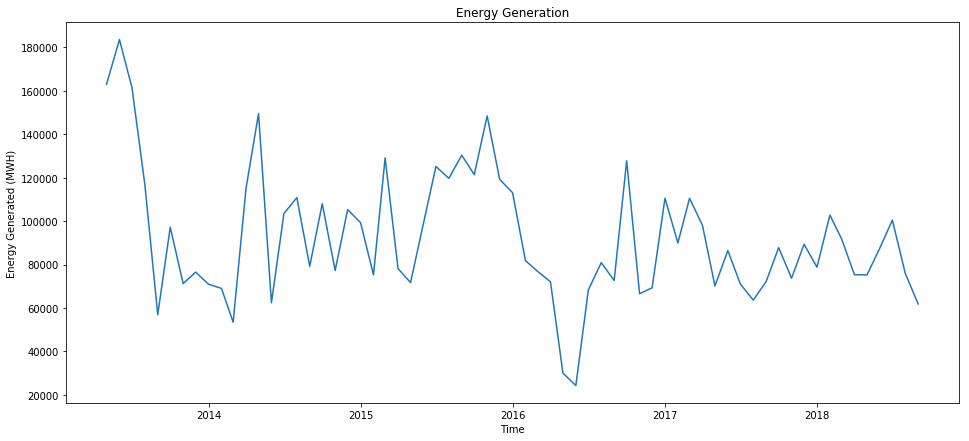

In [18]:
# Plot of energy generated over the time period
plt.figure(figsize=(16,7))
plt.plot(df['month'],df['energy_gen'])
plt.xlabel('Time')
plt.ylabel('Energy Generated (MWH)')
plt.title('Energy Generation')

In [19]:
# Create new columns for month and year
df['year'] = df.month.dt.year
df['month_new'] = df['month'].dt.strftime('%b')
df.head()

,month,energy_gen,year,month_new
0,2013-05-01,163035.0,2013,May
1,2013-06-01,183618.2,2013,Jun
2,2013-07-01,161546.8,2013,Jul
3,2013-08-01,116802.9,2013,Aug
4,2013-09-01,56931.0,2013,Sep


Lets plot a stacked line chart for each month to get possible insight in monthly trend 

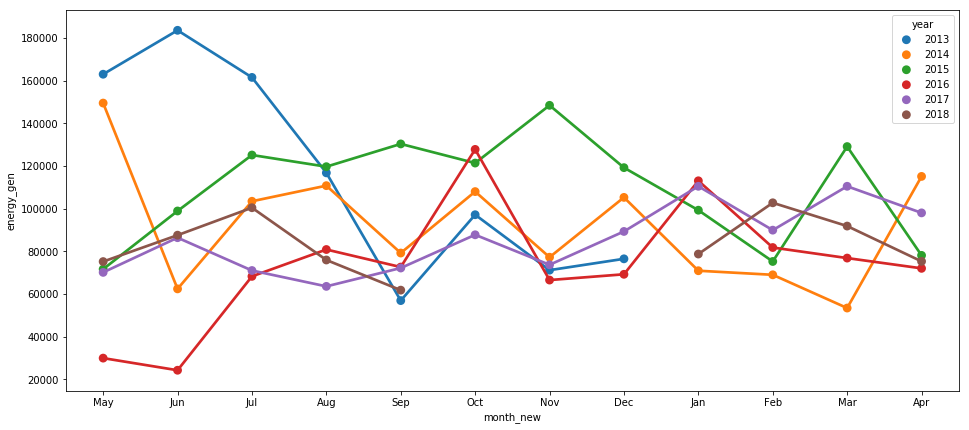

In [20]:
plt.figure(figsize=(16,7))
sns.pointplot(x='month_new',y='energy_gen',hue='year',data=df)

It looks like september-october-november always have a decrease-increase-decrease trend respectively in energy generation over the years except in 2015, where it was otherwise. Generally, unfortunately, it appears like the data is a victim of high irregularities caused by unpredictable influences such as strike, equipment breakdown amongst other downtimes. 

Text(0.5,1,'Energy Generated')

<Figure size 1152x504 with 0 Axes>

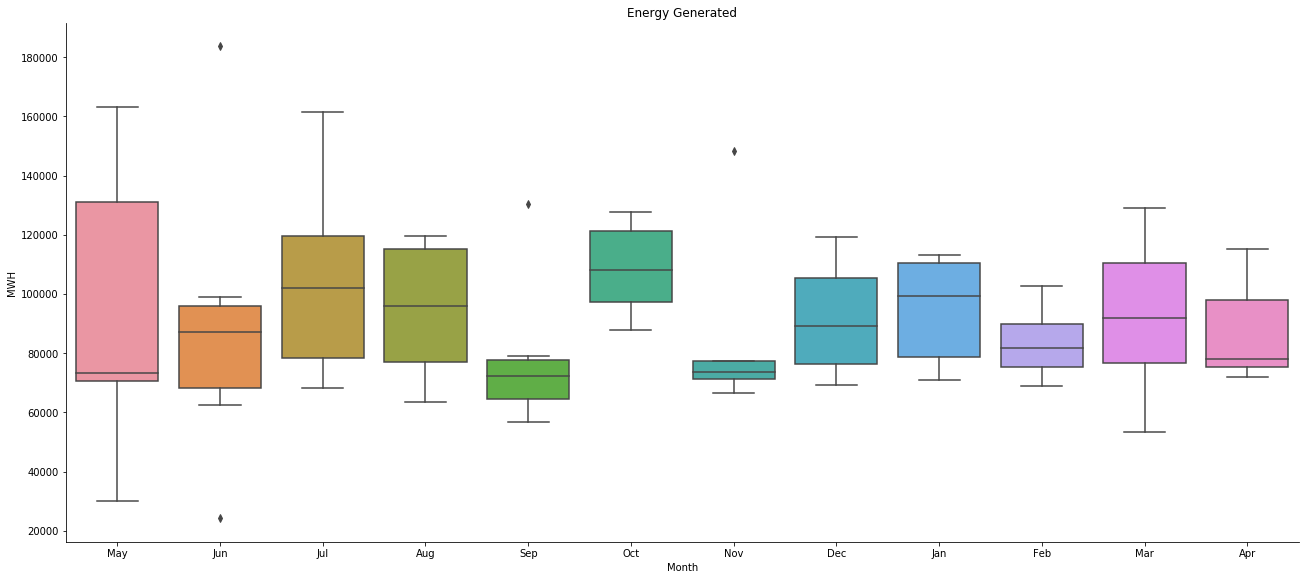

In [21]:
plt.figure(figsize=(16, 7))
sns.factorplot(x="month_new", y="energy_gen", data=df, kind="box", row_order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec'], size=8, aspect=float(16/7))
plt.xlabel("Month")
plt.ylabel("MWH")
plt.title("Energy Generated")

For some reason, April and May do not seem well distributed

Lets observe the yearly and monthly trend in energy generated

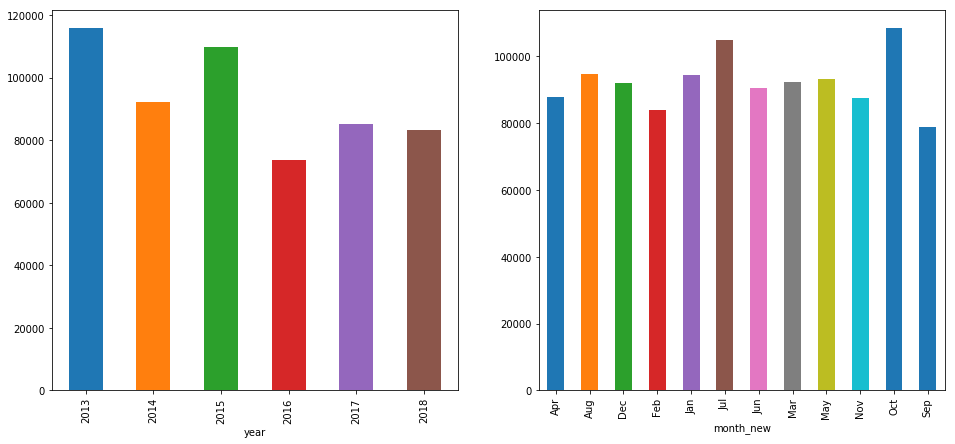

In [36]:
plt.figure(figsize=(16,7))
plt.subplot(121)
df.groupby('year')['energy_gen'].mean().plot.bar()
plt.subplot(122)
df.groupby('month_new')['energy_gen'].mean().plot.bar()

October and September cummulatively represent months with the highest and lowest energy generation respectively

In [37]:
# Indexing the datetime data type
decompose = df[["month", "energy_gen"]]
decompose.index = df["month"]
decompose = decompose[["energy_gen"]]
decompose.head()

,energy_gen
month,
2013-05-01,163035.0
2013-06-01,183618.2
2013-07-01,161546.8
2013-08-01,116802.9
2013-09-01,56931.0


Decomposing the time series data to check for trend, seasonality, and residuals.

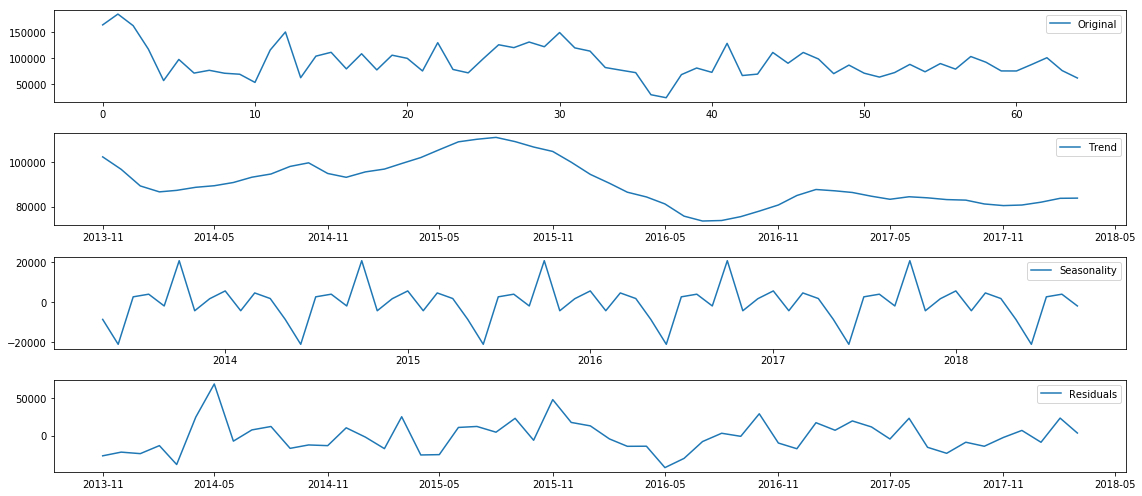

In [38]:
decomposition = seasonal_decompose(decompose)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(16, 7))
plt.subplot(411)
plt.plot(df["energy_gen"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Train and Test data split

In [39]:
df1 = decompose
x_train = df1[df1.index < datetime.datetime(2017,1,1,0,0,0)]
x_test = df1[df1.index >= datetime.datetime(2017,1,1,0,0,0)]
print(x_train.shape,x_test.shape)

(44, 1) (21, 1)


### Test for stationarity

ARIMA forecasting models assume time series is stationary (series is independent of time). Running an Augmented Dickey-Fuller (ADF) helps confirm stationarity

Test Statistic                 -3.915684
p-value                         0.001922
#Lags Used                      0.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


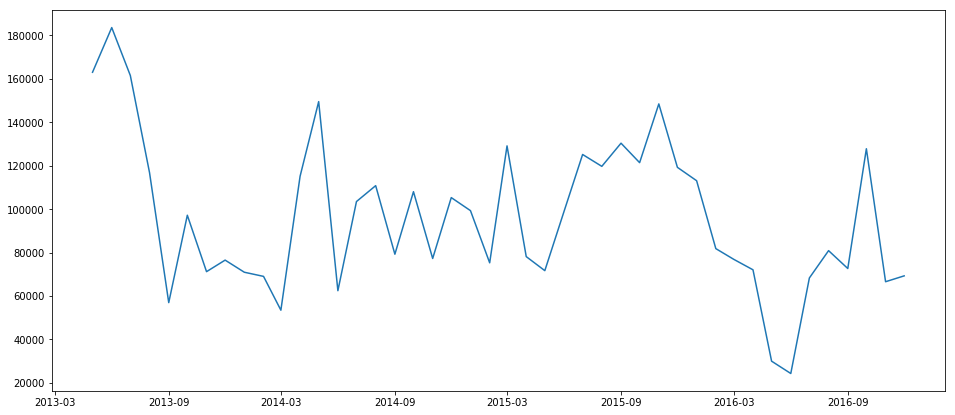

In [40]:
def stationary_test(data):
    dftest = adfuller(data.energy_gen,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    plt.figure(figsize=(16, 7))
    plt.plot(data.index, data.energy_gen)
stationary_test(x_train)

Test statistics less than 95% CI (Critical value 5%) proves data stationarity

### ACF and PACF plots

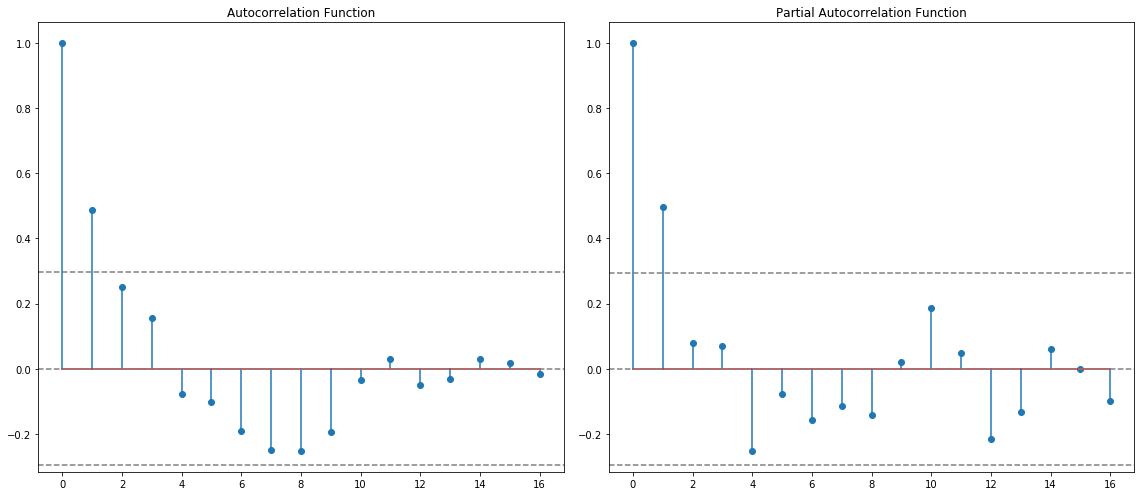

In [28]:
#ACF and PACF plots to estimate p,q values
lag_acf = acf(x_train,nlags=16)
lag_pacf = pacf(x_train,nlags=16,method='ols')

plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_train)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_train)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Data Transformation

Test Statistic                 -3.872514
p-value                         0.002247
#Lags Used                      0.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


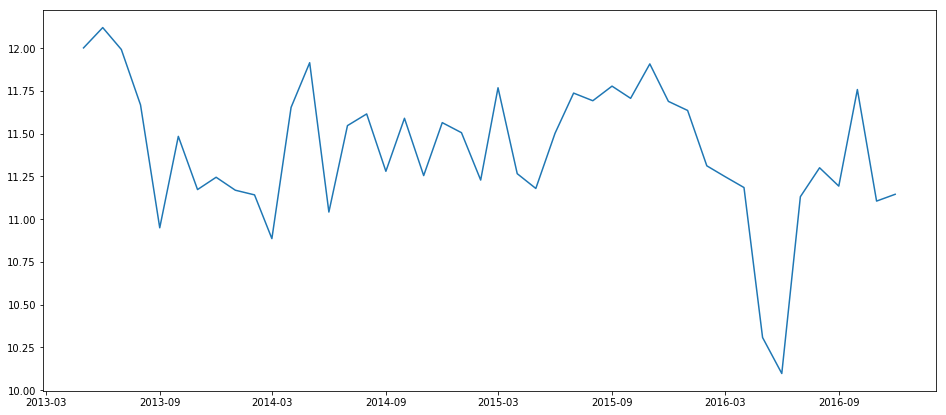

In [42]:
# Transformation of data using Boxcox
box_cox_train = stats.boxcox(x_train,lmbda=0)
box_cox_train = pd.DataFrame(data=box_cox_train)
box_cox_train.index = x_train.index
box_cox_train.columns = ['energy_gen']
stationary_test(box_cox_train)

### AR Model

RMSE: 16250.359647248133
MSE: 264074188.6649105
MAE: 13628.364485533351
MAPE: 17.2177533000404 %


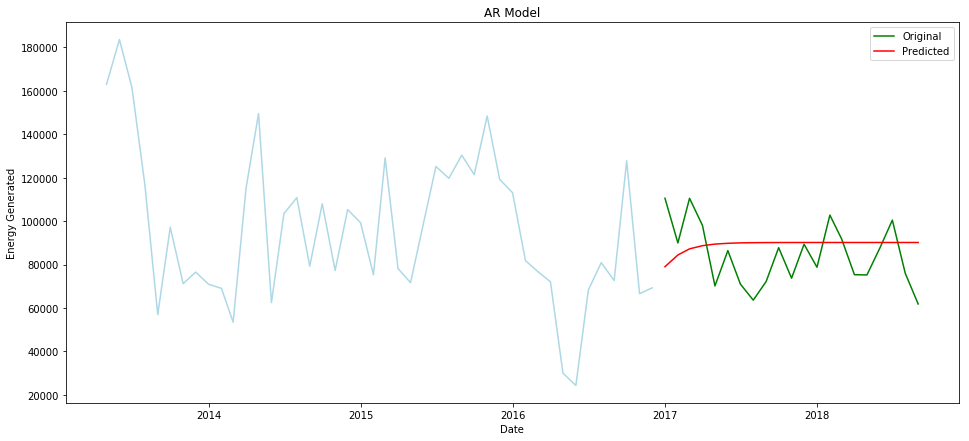

In [50]:
## AR Model p=1, d=0, q=0 
model = ARIMA(box_cox_train, order=(1, 0, 0))  
results_AR = model.fit(disp=-1)  

plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green",label='Original')

## Forecasting 
pred = pd.DataFrame(results_AR.forecast(len(x_test))[0])
pred.columns = ["energy_gen"]
pred.index = x_test.index

## Converting from log to normal value
pred["energy_gen"] = pred["energy_gen"].apply(lambda x: math.exp(x)-1)

## Measuring error. 
RMSE = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
MSE = mean_squared_error(x_test.values,pred.values)
MAE = mean_absolute_error(x_test.values,pred.values)
MAPE = float(sum(abs((x_test.values - pred.values)/(x_test.values)) * 100)/len(x_test))
print('RMSE: {}'.format(RMSE))
print('MSE: {}'.format(MSE))
print('MAE: {}'.format(MAE))
print('MAPE: {} %'.format(MAPE))
plt.plot(pred.index, pred.fillna(0).values, color="red",label='Predicted')

plt.xlabel('Date')
plt.ylabel('Energy Generated')
plt.title('AR Model')
plt.legend()

### MA Model

RMSE: 14980.209519277969
MSE: 224406677.24146625
MAE: 12526.911545145495
MAPE: 16.106386086836956 %


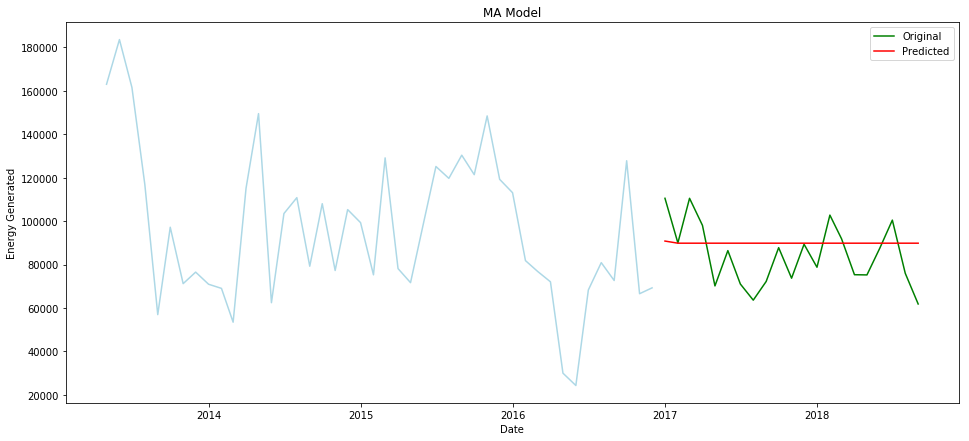

In [51]:
## MA Model p=0, d=0, q=1
model = ARIMA(box_cox_train, order=(0, 0, 1))  
results_AR = model.fit()  

plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green",label='Original')

## Forecasting 
pred = pd.DataFrame(results_AR.forecast(len(x_test))[0])
pred.columns = ["energy_gen"]
pred.index = x_test.index

## Converting from log to normal value
pred["energy_gen"] = pred["energy_gen"].apply(lambda x: math.exp(x)-1)

## Measuring error. 
RMSE = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
MSE = mean_squared_error(x_test.values,pred.values)
MAE = mean_absolute_error(x_test.values,pred.values)
MAPE = float(sum(abs((x_test.values - pred.values)/(x_test.values)) * 100)/len(x_test))
print('RMSE: {}'.format(RMSE))
print('MSE: {}'.format(MSE))
print('MAE: {}'.format(MAE))
print('MAPE: {} %'.format(MAPE))
plt.plot(pred.index, pred.fillna(0).values, color="red",label='Predicted')

plt.xlabel('Date')
plt.ylabel('Energy Generated')
plt.title('MA Model')
plt.legend()

### ARIMA Model

RMSE: 16341.663515351549
MSE: 267049966.44897193
MAE: 13720.60354593654
MAPE: 17.31557974424228 %


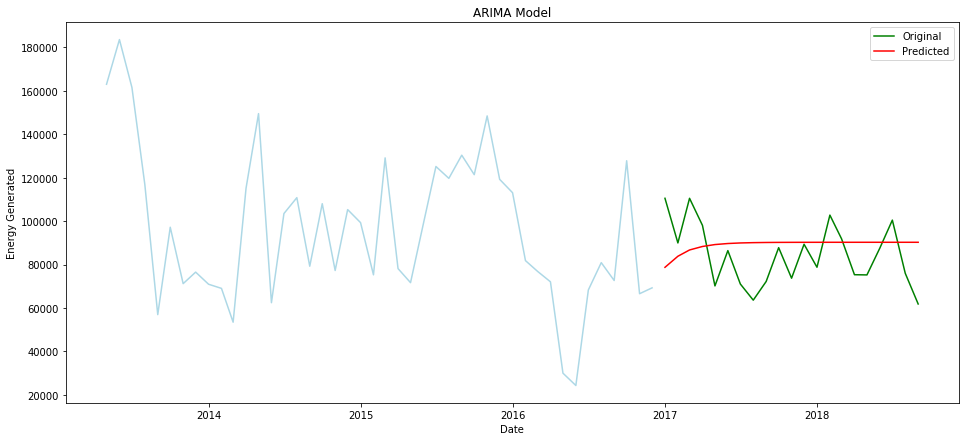

In [52]:
## ARIMA Model p=1, d=0, q=1 
model = ARIMA(box_cox_train, order=(1, 0, 1))  
results_AR = model.fit()  

plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green",label='Original')

## Forecasting 
pred = pd.DataFrame(results_AR.forecast(len(x_test))[0])
pred.columns = ["energy_gen"]
pred.index = x_test.index

## Converting from log to normal value
pred["energy_gen"] = pred["energy_gen"].apply(lambda x: math.exp(x)-1)

## Measuring error. 
RMSE = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
MSE = mean_squared_error(x_test.values,pred.values)
MAE = mean_absolute_error(x_test.values,pred.values)
MAPE = float(sum(abs((x_test.values - pred.values)/(x_test.values)) * 100)/len(x_test))
print('RMSE: {}'.format(RMSE))
print('MSE: {}'.format(MSE))
print('MAE: {}'.format(MAE))
print('MAPE: {} %'.format(MAPE))
plt.plot(pred.index, pred.fillna(0).values, color="red",label='Predicted')

plt.xlabel('Date')
plt.ylabel('Energy Generated')
plt.title('ARIMA Model')
plt.legend()

### SARIMAX Model

In [91]:
pdq = [1,0,1]
print('Possible Orders:')
print(pdq)
print('Possible Seasonal Orders:')
i = j = k = range(0, 2)
a = [4,7]
for w in list(a):
    seasonal_pdq = [(x[0], x[1], x[2],w) for x in list(itertools.product(i, j, k))]
print(seasonal_pdq)

Possible Orders:
[1, 0, 1]
Possible Seasonal Orders:
[(0, 0, 0, 7), (0, 0, 1, 7), (0, 1, 0, 7), (0, 1, 1, 7), (1, 0, 0, 7), (1, 0, 1, 7), (1, 1, 0, 7), (1, 1, 1, 7)]


In [89]:
for param_seasonal in seasonal_pdq:
    mod = sm.tsa.statespace.SARIMAX(box_cox_train.energy_gen,order=(1,0,1),
                                            seasonal_order=param_seasonal,enforce_stationarity=False,
                                            enforce_invertibility=False)
    results = mod.fit()
    print('{} x {} - AIC:{}'.format(param, param_seasonal, results.aic))

[(1, 0, 1)] x (0, 0, 0, 7) - AIC:43.555430831393664
[(1, 0, 1)] x (0, 0, 1, 7) - AIC:39.90484057239706
[(1, 0, 1)] x (0, 1, 0, 7) - AIC:57.68300953008318
[(1, 0, 1)] x (0, 1, 1, 7) - AIC:36.89803872046511
[(1, 0, 1)] x (1, 0, 0, 7) - AIC:37.82306666486734
[(1, 0, 1)] x (1, 0, 1, 7) - AIC:49.266515956371116
[(1, 0, 1)] x (1, 1, 0, 7) - AIC:37.49788107250319
[(1, 0, 1)] x (1, 1, 1, 7) - AIC:38.76725799182674


In [90]:
mod = sm.tsa.statespace.SARIMAX(box_cox_train.energy_gen,order=(1, 0, 1),seasonal_order=(0, 1, 1, 7),enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6593      0.387      1.704      0.088      -0.099       1.418
ma.L1         -0.2302      0.527     -0.436      0.663      -1.264       0.804
ma.S.L7       -0.7097      0.716     -0.992      0.321      -2.112       0.693
sigma2         0.1533      0.061      2.526      0.012       0.034       0.272


RMSE: 17595.40870155594
MSE: 309598407.3747905
MAE: 12407.609659675907
MAPE: 13.983405747995175 %


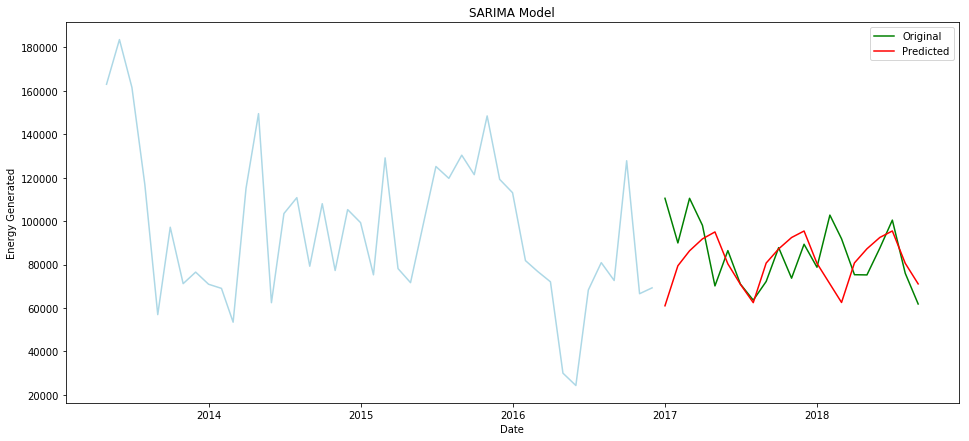

In [92]:
mod = sarimax.SARIMAX(box_cox_train.energy_gen,order=(1,0,1),seasonal_order=(0,1,1,7),enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit(disp=-1)

plt.figure(figsize=(16, 7))
plt.plot(x_train.index,x_train.values,color='lightblue')
plt.plot(x_test.index,x_test.values,color='green',label='Original')

pred = pd.DataFrame(results.forecast(len(x_test)))
pred.columns = ['energy_gen']
pred.index = x_test.index

## Converting from log to normal value
pred["energy_gen"] = pred["energy_gen"].apply(lambda x: math.exp(x)-1)

## Measuring error. 
RMSE = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
MSE = mean_squared_error(x_test.values,pred.values)
MAE = mean_absolute_error(x_test.values,pred.values)
MAPE = float(sum(abs((x_test.values - pred.values)/(x_test.values)) * 100)/len(x_test))
print('RMSE: {}'.format(RMSE))
print('MSE: {}'.format(MSE))
print('MAE: {}'.format(MAE))
print('MAPE: {} %'.format(MAPE))
plt.plot(pred.index, pred.fillna(0).values, color="red",label='Predicted')

plt.xlabel('Date')
plt.ylabel('Energy Generated')
plt.title('SARIMA Model')
plt.legend()

## Holt Winter's

RMSE: 18281.26765060961
MSE: 334204746.9132255
MAE: 13152.175510220493
MAPE: 14.585959630570771 %


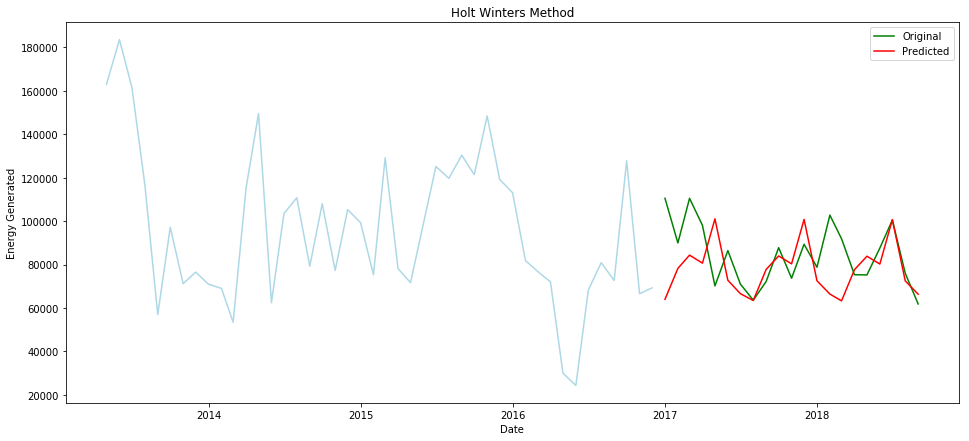

In [93]:
fit = ExponentialSmoothing(np.asarray(x_train['energy_gen']) ,seasonal_periods=7 ,damped=True,
                           trend='add', seasonal='add',).fit()  
plt.figure(figsize=(16,7)) 
plt.plot(x_train.index, x_train.values, color="lightblue") 
plt.plot(x_test.index, x_test.values, color="green",label='Original') 

## Forecasting 
pred = pd.DataFrame(fit.forecast(len(x_test)))
pred.columns = ["energy_gen"]
pred.index = x_test.index

## Measuring error. 
RMSE = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
MSE = mean_squared_error(x_test.values,pred.values)
MAE = mean_absolute_error(x_test.values,pred.values)
MAPE = float(sum(abs((x_test.values - pred.values)/(x_test.values)) * 100)/len(x_test))
print('RMSE: {}'.format(RMSE))
print('MSE: {}'.format(MSE))
print('MAE: {}'.format(MAE))
print('MAPE: {} %'.format(MAPE))
plt.plot(pred.index, pred.fillna(0).values, color="red",label='Predicted')

plt.xlabel('Date')
plt.ylabel('Energy Generated')
plt.title('Holt Winters Method')
plt.legend()

In conclusion, the SARIMA model did best having a MAPE of about 13.98%, the holt winter's model comes close with 14.5%. It should also be stated that the data used in this project is limited for it has just 65 observations. It is expected that with larger time series data, models should perform better.